In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

# Load Model

In [2]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "darkroom_simple"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd256_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0.0_initseed0_batch1024"


model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{wandb_project}/{env_name}/datasets/eval.pkl"

epoch=8-val_loss=0.857135.ckpt


In [3]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [4]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_877136/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [5]:
n_eval_envs = 100

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [6]:
seq_length = 150

In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    outputs = []
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            outputs.append(torch.argmax(out).item())
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states, outputs

# Across context decoding

In [8]:
def get_subtree_location(pos, subtree):
    x, y = pos
    midpt = maze_dim//2
    if subtree == 'half':
        return 0 if x < midpt else 1
    elif subtree == 'quarter':
        if x < midpt:
            if y < midpt:
                return 0
            else:
                return 1
        else:
            if y < midpt:
                return 2
            else:
                return 3
    

In [13]:
def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "angle_from_goal": [],
        "value": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        "inverse_action": [],
        "action": []
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, outputs = run_model(traj, model, seen_states, seq_length)
        goal_node = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
        for state_idx, state_feature in enumerate(seen_states):
            state_feature_tuple = tuple(state_feature.tolist())
            state_feature_tuple = tuple(state_feature.tolist())
            action = outputs[state_idx]
            d = dist_from_goal[state_feature_tuple]
            node_identity = env.node_map_encoding_to_pos[state_feature_tuple]
            maze_half = get_subtree_location(node_identity, 'half')
            maze_quarter = get_subtree_location(node_identity, 'quarter')
            if action == 0:
                inverse_action = 2
            elif action == 1:
                inverse_action = 3
            elif action == 2:
                inverse_action = 0
            elif action == 3:
                inverse_action = 1
            else:
                inverse_action = 4
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["angle_from_goal"].append(
                np.arctan2(goal_node[1] - node_identity[1], goal_node[0] - node_identity[0])
                )
            Ys_dict["value"].append(0.7**d)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_node, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_node, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["inverse_action"].append(inverse_action)
            Ys_dict["action"].append(action)
            
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx][0, -1].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()

    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [21]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

        if make_plot:
            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 3, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

        if make_plot:
            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(3, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [22]:
def fit_and_evaluate_circular_regression(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    import numpy as np
    
    # Convert angles to sine and cosine components
    def angle_to_sin_cos(angles):
        return np.column_stack((np.sin(angles), np.cos(angles)))
    
    # Convert sine and cosine predictions back to angles
    def sin_cos_to_angle(sin_vals, cos_vals):
        return np.arctan2(sin_vals, cos_vals)
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)
    
    # Convert target angles to sin/cos components
    Y_train_sin = np.sin(Y_train_np)
    Y_train_cos = np.cos(Y_train_np)
    Y_test_sin = np.sin(Y_test_np)
    Y_test_cos = np.cos(Y_test_np)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y_sin, y_cos, train_idx, val_idx, alpha):
        # Train sin model
        sin_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        sin_pipeline.fit(X[train_idx], y_sin[train_idx])
        
        # Train cos model
        cos_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        cos_pipeline.fit(X[train_idx], y_cos[train_idx])
        
        # Predict and convert back to angles
        sin_pred = sin_pipeline.predict(X[val_idx])
        cos_pred = cos_pipeline.predict(X[val_idx])
        angle_pred = sin_cos_to_angle(sin_pred, cos_pred)
        
        # Calculate circular error
        true_angles = np.arctan2(y_sin[val_idx], y_cos[val_idx])
        errors = np.abs(np.arctan2(np.sin(angle_pred - true_angles), np.cos(angle_pred - true_angles)))
        mean_circular_error = np.mean(errors)
        
        # Return negative error as score (higher is better)
        return -mean_circular_error

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_sin, Y_train_cos, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha (lowest error)
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final sin model with best alpha
        sin_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        sin_pipeline.fit(X_train_np[layer], Y_train_sin)
        
        # Train final cos model with best alpha
        cos_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        cos_pipeline.fit(X_train_np[layer], Y_train_cos)
        
        # Evaluate on train set
        train_sin_pred = sin_pipeline.predict(X_train_np[layer])
        train_cos_pred = cos_pipeline.predict(X_train_np[layer])
        train_angle_pred = sin_cos_to_angle(train_sin_pred, train_cos_pred)
        train_errors = np.abs(np.arctan2(np.sin(train_angle_pred - Y_train_np), np.cos(train_angle_pred - Y_train_np)))
        train_mean_error = np.mean(train_errors)
        
        # Evaluate on test set
        test_sin_pred = sin_pipeline.predict(X_test_np[layer])
        test_cos_pred = cos_pipeline.predict(X_test_np[layer])
        test_angle_pred = sin_cos_to_angle(test_sin_pred, test_cos_pred)
        test_errors = np.abs(np.arctan2(np.sin(test_angle_pred - Y_test_np), np.cos(test_angle_pred - Y_test_np)))
        test_mean_error = np.mean(test_errors)
        
        pipelines.append((sin_pipeline, cos_pipeline))
        test_scores.append(-test_mean_error)  # Store negative error as score
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train mean circular error: {train_mean_error:.3f} radians ({np.degrees(train_mean_error):.1f}°)")
            print(f"Test mean circular error: {test_mean_error:.3f} radians ({np.degrees(test_mean_error):.1f}°)")
            print()

        if make_plot:
            plt.figure(figsize=(5, 5))
            
            # Plot on a circle
            ax = plt.subplot(111, projection='polar')
            ax.scatter(Y_test_np, np.ones_like(Y_test_np), alpha=0.5, label='True')
            ax.scatter(test_angle_pred, np.ones_like(test_angle_pred)*0.8, alpha=0.5, label='Predicted')
            
            # Draw lines connecting true and predicted values
            for i in range(len(Y_test_np)):
                ax.plot([Y_test_np[i], test_angle_pred[i]], [1, 0.8], 'k-', alpha=0.1)
            
            ax.set_rticks([])  # Hide radial ticks
            ax.set_title(f'Layer {layer}: True vs Predicted Angles')
            ax.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Also show a scatter plot of true vs predicted
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, test_angle_pred, alpha=0.5)
            plt.xlabel('True Angle (radians)')
            plt.ylabel('Predicted Angle (radians)')
            plt.title(f'Layer {layer}: True vs Predicted Angles')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

In [16]:
X_train, X_test, Ys_dict = make_train_test_matrices()

Layer 0:
Best alpha: 166.810
Train R2: 0.759
Test R2: 0.712



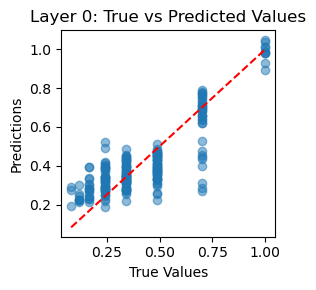

Layer 1:
Best alpha: 59.948
Train R2: 0.886
Test R2: 0.873



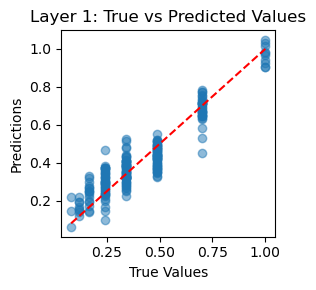

Layer 2:
Best alpha: 21.544
Train R2: 0.905
Test R2: 0.896



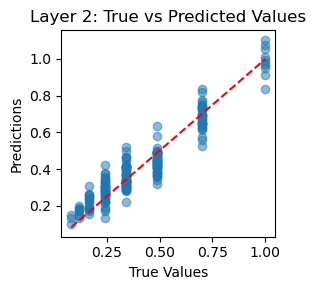

In [23]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["value"]["Y_train"], X_test, Ys_dict["value"]["Y_test"])

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.600
Test Balanced Accuracy: 0.370
Train Weighted F1: 0.470
Test Weighted F1: 0.333
Class distribution:
Class 0: 81 samples
Class 1: 289 samples
Class 2: 509 samples
Class 3: 537 samples
Class 4: 331 samples
Class 5: 132 samples
Class 6: 66 samples
Class 7: 30 samples



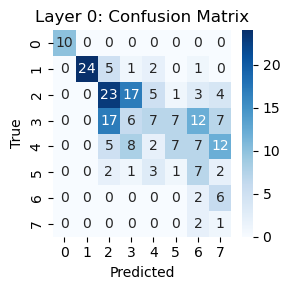


Layer 1:
Best C: 0.001
Train Balanced Accuracy: 0.719
Test Balanced Accuracy: 0.417
Train Weighted F1: 0.615
Test Weighted F1: 0.472
Class distribution:
Class 0: 81 samples
Class 1: 289 samples
Class 2: 509 samples
Class 3: 537 samples
Class 4: 331 samples
Class 5: 132 samples
Class 6: 66 samples
Class 7: 30 samples



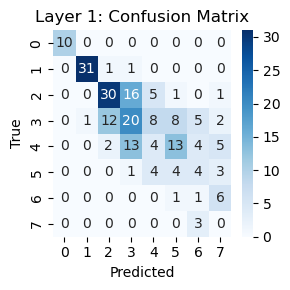


Layer 2:
Best C: 2.154
Train Balanced Accuracy: 0.973
Test Balanced Accuracy: 0.493
Train Weighted F1: 0.947
Test Weighted F1: 0.556
Class distribution:
Class 0: 81 samples
Class 1: 289 samples
Class 2: 509 samples
Class 3: 537 samples
Class 4: 331 samples
Class 5: 132 samples
Class 6: 66 samples
Class 7: 30 samples



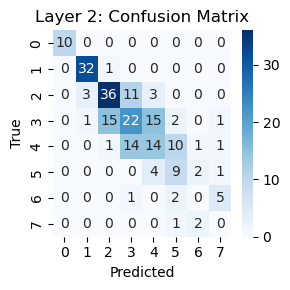

In [24]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["dist_from_goal"]["Y_train"], X_test, Ys_dict["dist_from_goal"]["Y_test"])

Layer 0:
Best alpha: 59.948
Train mean circular error: 0.342 radians (19.6°)
Test mean circular error: 0.403 radians (23.1°)



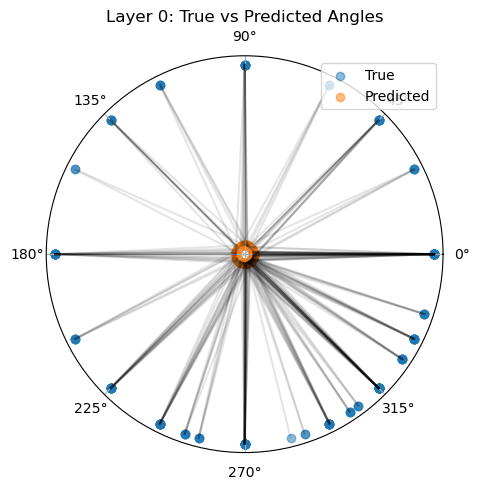

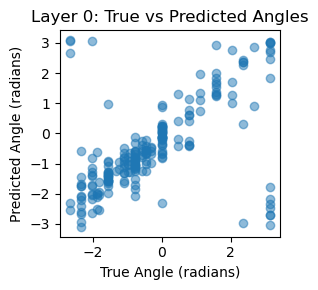

Layer 1:
Best alpha: 166.810
Train mean circular error: 0.168 radians (9.6°)
Test mean circular error: 0.216 radians (12.4°)



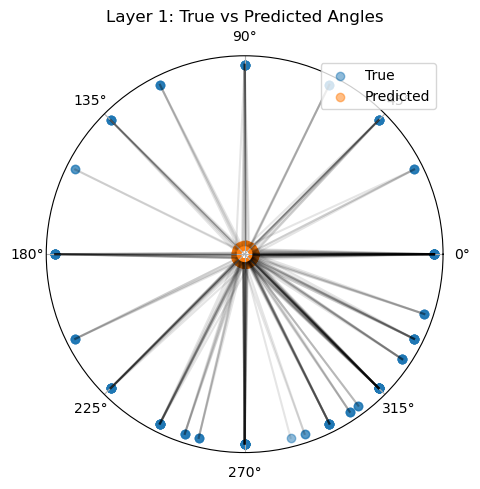

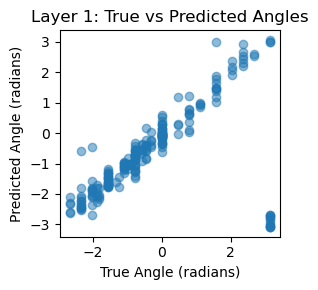

Layer 2:
Best alpha: 21.544
Train mean circular error: 0.124 radians (7.1°)
Test mean circular error: 0.166 radians (9.5°)



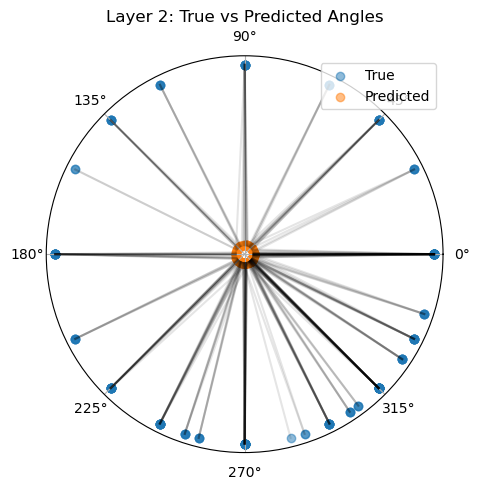

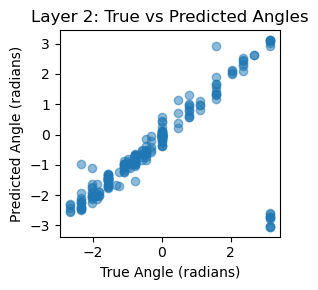

In [25]:
pipeline, test_score = fit_and_evaluate_circular_regression(
    X_train, 
    Ys_dict["angle_from_goal"]["Y_train"], 
    X_test, 
    Ys_dict["angle_from_goal"]["Y_test"]
)

In [29]:
_Y_train = [y[0] for y in Ys_dict["node_identity"]["Y_train"]]
_Y_test = [y[0] for y in Ys_dict["node_identity"]["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test, make_plot=False)

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.825
Test Balanced Accuracy: 0.578
Train Weighted F1: 0.819
Test Weighted F1: 0.574
Class distribution:
Class 0: 380 samples
Class 1: 398 samples
Class 2: 408 samples
Class 3: 404 samples
Class 4: 385 samples

Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.913
Test Balanced Accuracy: 0.791
Train Weighted F1: 0.911
Test Weighted F1: 0.792
Class distribution:
Class 0: 380 samples
Class 1: 398 samples
Class 2: 408 samples
Class 3: 404 samples
Class 4: 385 samples

Layer 2:
Best C: 0.464
Train Balanced Accuracy: 0.994
Test Balanced Accuracy: 0.816
Train Weighted F1: 0.994
Test Weighted F1: 0.818
Class distribution:
Class 0: 380 samples
Class 1: 398 samples
Class 2: 408 samples
Class 3: 404 samples
Class 4: 385 samples



In [30]:
_Y_train = [y[1] for y in Ys_dict["node_identity"]["Y_train"]]
_Y_test = [y[1] for y in Ys_dict["node_identity"]["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test, make_plot=False)

Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.884
Test Balanced Accuracy: 0.553
Train Weighted F1: 0.882
Test Weighted F1: 0.534
Class distribution:
Class 0: 393 samples
Class 1: 411 samples
Class 2: 399 samples
Class 3: 395 samples
Class 4: 377 samples

Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.907
Test Balanced Accuracy: 0.739
Train Weighted F1: 0.905
Test Weighted F1: 0.738
Class distribution:
Class 0: 393 samples
Class 1: 411 samples
Class 2: 399 samples
Class 3: 395 samples
Class 4: 377 samples

Layer 2:
Best C: 0.100
Train Balanced Accuracy: 0.960
Test Balanced Accuracy: 0.814
Train Weighted F1: 0.960
Test Weighted F1: 0.808
Class distribution:
Class 0: 393 samples
Class 1: 411 samples
Class 2: 399 samples
Class 3: 395 samples
Class 4: 377 samples



Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.921
Test Balanced Accuracy: 0.800
Train Weighted F1: 0.918
Test Weighted F1: 0.801
Class distribution:
Class 0: 778 samples
Class 1: 1197 samples



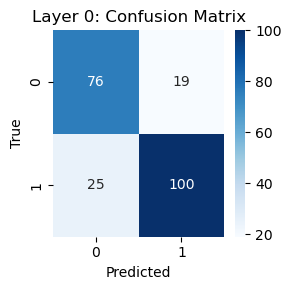


Layer 1:
Best C: 0.005
Train Balanced Accuracy: 0.953
Test Balanced Accuracy: 0.916
Train Weighted F1: 0.951
Test Weighted F1: 0.914
Class distribution:
Class 0: 778 samples
Class 1: 1197 samples



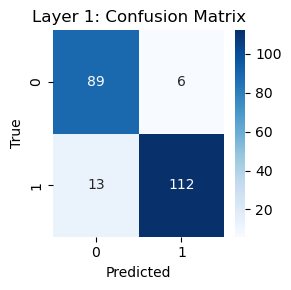


Layer 2:
Best C: 0.464
Train Balanced Accuracy: 0.993
Test Balanced Accuracy: 0.947
Train Weighted F1: 0.993
Test Weighted F1: 0.946
Class distribution:
Class 0: 778 samples
Class 1: 1197 samples



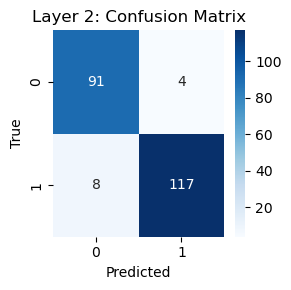

In [27]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.861
Test Balanced Accuracy: 0.630
Train Weighted F1: 0.853
Test Weighted F1: 0.634
Class distribution:
Class 0: 315 samples
Class 1: 463 samples
Class 2: 489 samples
Class 3: 708 samples



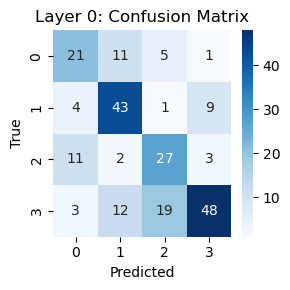


Layer 1:
Best C: 0.005
Train Balanced Accuracy: 0.921
Test Balanced Accuracy: 0.845
Train Weighted F1: 0.916
Test Weighted F1: 0.851
Class distribution:
Class 0: 315 samples
Class 1: 463 samples
Class 2: 489 samples
Class 3: 708 samples



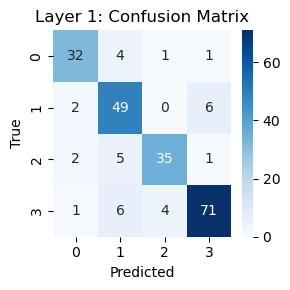


Layer 2:
Best C: 0.100
Train Balanced Accuracy: 0.986
Test Balanced Accuracy: 0.926
Train Weighted F1: 0.984
Test Weighted F1: 0.932
Class distribution:
Class 0: 315 samples
Class 1: 463 samples
Class 2: 489 samples
Class 3: 708 samples



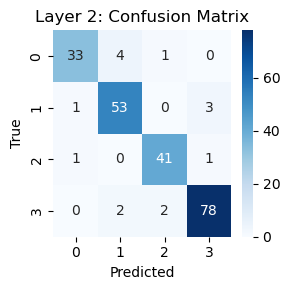

In [28]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_quarter"]["Y_train"], X_test, Ys_dict["maze_quarter"]["Y_test"])